## **Mount implementation folder in google drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd /content/drive/MyDrive/FYP/Implementation/data
! ls

/content/drive/.shortcut-targets-by-id/1MkC_V0CRXkQ-OsCBxF38m1Sku4w4s3TR/FYP/Implementation/data
encoded-data.csv	preprosessing-dos.csv	  UNSW-NB15_1.csv
NUSW-NB15_features.csv	selected_columns_all.csv  UNSW-NB15_2.csv
OTset.csv		SVR-predict-data.csv	  UNSW-NB15_3.csv
preprocessing.csv	testset.csv		  UNSW-NB15_4.csv


## **Load balanced training datset for DOS attacks**

Data = (x_train, y_train)

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle

#get select columns for training
select_col=pd.read_csv("selected_columns_all.csv", sep=',', on_bad_lines='skip', index_col=False)
col=list(select_col['Generic'])


#create training dataset down sampling
df = pd.read_csv('encoded-data.csv', sep=',', on_bad_lines='skip', index_col=False)
attack_labels = ['Analysis', 'Backdoors', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Reconnaissance', 'Shellcode', 'Worms'] + ['attack_cat','Label']


Exploits_attacks = df[df['Generic'] == 1]
Normal_Data = df[df['Label'] == 0]
frames = [Exploits_attacks, Normal_Data]
result = pd.concat(frames)
X=result.drop(labels=attack_labels, axis=1)
Y=result[['Generic']]
X.head()

undersample = RandomUnderSampler(random_state=0)
# fit and apply the transform
X, Y = undersample.fit_resample(X,Y)


x_train,y_train  = shuffle(X[col],Y)


X_train_normalized = preprocessing.normalize(x_train)
X_train_normalized 




array([[5.01315816e-06, 0.00000000e+00, 1.18421059e-07, ...,
        1.77631588e-13, 0.00000000e+00, 0.00000000e+00],
       [5.01315816e-06, 0.00000000e+00, 1.18421059e-07, ...,
        1.77631588e-13, 0.00000000e+00, 0.00000000e+00],
       [6.48019115e-05, 6.06211430e-05, 4.18076848e-06, ...,
        2.27224767e-09, 1.69321124e-04, 3.38642247e-04],
       ...,
       [5.77003351e-05, 5.39777328e-05, 3.72260226e-06, ...,
        2.02323433e-09, 1.65655801e-04, 3.31311602e-04],
       [5.57017544e-07, 0.00000000e+00, 1.31578947e-08, ...,
        2.19298246e-15, 0.00000000e+00, 0.00000000e+00],
       [5.40907423e-05, 5.06010170e-05, 3.48972531e-06, ...,
        1.77801505e-09, 1.55292776e-04, 3.10585553e-04]])

## **Create Test Set for DOS attacks**

Data = (x_test_DOS_normalized, y_test)

In [4]:
import pandas as pd
import numpy as np
select_col=pd.read_csv("selected_columns_all.csv", sep=',', on_bad_lines='skip', index_col=False)

columns=list(select_col['Generic'])

test_data =pd.read_csv("testset.csv", sep=',', on_bad_lines='skip', index_col=False)
attack_labels = ['Analysis', 'Backdoors', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Reconnaissance', 'Shellcode', 'Worms'] + ['attack_cat','Label']
attack_categories = ['Analysis', 'Backdoors', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Reconnaissance', 'Shellcode', 'Worms'] 

Exploits_attacks  = test_data[test_data['attack_cat'] == 'Exploits']
# print(DoS_attacks.shape)
Normal_Data = test_data[test_data['Label'] == 0]
# print(Normal_Data.shape)

frames = [Exploits_attacks , Normal_Data]
result = pd.concat(frames)
X=result.drop(labels=['attack_cat', 'Label'], axis=1)
Y=result[['Label']]
X.head()

x_test,y_test  = shuffle(X[columns],Y)

x_test = x_test.replace('-','')
x_test = x_test.replace(r'^\s*$', np.nan, regex=True)

#delete raws with missing values
for i in x_test.columns.values.tolist():
  i = x_test.loc[x_test[i].isnull()].index
  x_test = x_test.drop(index=list(i))
  y_test = y_test.drop(index=list(i))

percent_missing = x_test.isnull().sum()
missing_value_df = pd.DataFrame({'column_name': x_test.columns, 'count_missing': percent_missing, 'To be dropped': (percent_missing > 45)})
# print(missing_value_df)

x_test.head()
#encode the data
from sklearn.preprocessing import LabelEncoder

# replace hex with int
# x_test['sport'] = x_test['sport'].astype(str).apply(int, base=16)
# x_test['dsport'] = x_test['dsport'].astype(str).apply(int, base=16)

# #Create an instance of Label-encoder
labelencoder = LabelEncoder() 

# # encode columns consists with strings
x_test['srcip'] = labelencoder.fit_transform(x_test['srcip'])
x_test['dstip'] = labelencoder.fit_transform(x_test['dstip'])
x_test['proto'] = labelencoder.fit_transform(x_test['proto'])
x_test['state'] = labelencoder.fit_transform(x_test['state'])

X_test_normalized = preprocessing.normalize(x_test) 


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


**Random Forrest Regression**

In [5]:
# Fitting Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

#training data
x = np.array(X_train_normalized)
y = np.array(y_train)


# Number of trees in random forest
n_estimators = [2, 4, 8, 16, 32, 64, 100]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,4]
# Minimum number of samples required to split a node
min_samples_split = [2,3, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}




 # create regressor object
regressor = GridSearchCV(RandomForestRegressor(random_state=0),param_grid,return_train_score=False)

# fit the regressor with x and y data
regressor.fit(x, y)


df = pd.DataFrame(regressor.cv_results_)
df

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.410811,0.005616,0.005724,0.000059,True,2,auto,1,2,2,"{'bootstrap': True, 'max_depth': 2, 'max_featu...",0.844835,0.839738,0.843404,0.841981,0.846071,0.843205,0.002210,175
1,0.870718,0.091745,0.008553,0.001099,True,2,auto,1,2,4,"{'bootstrap': True, 'max_depth': 2, 'max_featu...",0.844830,0.838912,0.842634,0.841236,0.845325,0.842588,0.002361,187
2,1.726288,0.109116,0.012767,0.000176,True,2,auto,1,2,8,"{'bootstrap': True, 'max_depth': 2, 'max_featu...",0.844851,0.836615,0.853180,0.839006,0.843128,0.843356,0.005713,169
3,3.494435,0.183777,0.023024,0.000913,True,2,auto,1,2,16,"{'bootstrap': True, 'max_depth': 2, 'max_featu...",0.844894,0.837275,0.847645,0.840270,0.843860,0.842789,0.003630,181
4,6.458167,0.136267,0.041969,0.001480,True,2,auto,1,2,32,"{'bootstrap': True, 'max_depth': 2, 'max_featu...",0.847941,0.835744,0.843795,0.839334,0.842785,0.841920,0.004131,193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,1.001475,0.059748,0.014956,0.000804,False,4,sqrt,2,5,8,"{'bootstrap': False, 'max_depth': 4, 'max_feat...",0.852814,0.837970,0.842337,0.854564,0.843674,0.846272,0.006367,154
332,2.212477,0.132083,0.026184,0.000730,False,4,sqrt,2,5,16,"{'bootstrap': False, 'max_depth': 4, 'max_feat...",0.856956,0.843559,0.850712,0.855992,0.849014,0.851246,0.004889,148
333,4.178777,0.212680,0.048788,0.002057,False,4,sqrt,2,5,32,"{'bootstrap': False, 'max_depth': 4, 'max_feat...",0.865875,0.857733,0.861248,0.855740,0.859870,0.860093,0.003445,124
334,8.500362,0.397496,0.091202,0.002486,False,4,sqrt,2,5,64,"{'bootstrap': False, 'max_depth': 4, 'max_feat...",0.859772,0.848987,0.852933,0.854913,0.854544,0.854230,0.003477,139


In [6]:
df[['param_bootstrap', 	'param_max_depth', 	'param_max_features', 	'param_min_samples_leaf', 	'param_min_samples_split', 	'param_n_estimators','mean_test_score']]

,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_test_score
0,True,2,auto,1,2,2,0.843205
1,True,2,auto,1,2,4,0.842588
2,True,2,auto,1,2,8,0.843356
3,True,2,auto,1,2,16,0.842789
4,True,2,auto,1,2,32,0.841920
...,...,...,...,...,...,...,...
331,False,4,sqrt,2,5,8,0.846272
332,False,4,sqrt,2,5,16,0.851246
333,False,4,sqrt,2,5,32,0.860093
334,False,4,sqrt,2,5,64,0.854230


In [7]:
regressor.best_params_

{'bootstrap': True,
 'max_depth': 4,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 4}

**Train the model**

In [8]:
from sklearn.ensemble import RandomForestRegressor

#training data
x = np.array(X_train_normalized)
y = np.array(y_train)


 # create regressor object
regressor = RandomForestRegressor(bootstrap=True,max_depth=4,max_features= 'auto',min_samples_leaf=1,min_samples_split=2,n_estimators=4)

# fit the regressor with x and y data
regressor.fit(x, y)

y_pred = regressor.predict(x)


<ipython-input-8-3f03917afd62>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(x, y)


In [9]:
from sklearn.metrics import accuracy_score

for i in range(1,100):
  y_predict_class = [1 if p > i/100 else 0 for p in y_pred]
  print("Accuracy when threshould = ",i/100, round(accuracy_score(y, y_predict_class), 6))

Accuracy when threshould =  0.01 0.941671
Accuracy when threshould =  0.02 0.941671
Accuracy when threshould =  0.03 0.941671
Accuracy when threshould =  0.04 0.941671
Accuracy when threshould =  0.05 0.96978
Accuracy when threshould =  0.06 0.96978
Accuracy when threshould =  0.07 0.96978
Accuracy when threshould =  0.08 0.96978
Accuracy when threshould =  0.09 0.96978
Accuracy when threshould =  0.1 0.96978
Accuracy when threshould =  0.11 0.96978
Accuracy when threshould =  0.12 0.96978
Accuracy when threshould =  0.13 0.969811
Accuracy when threshould =  0.14 0.969811
Accuracy when threshould =  0.15 0.969861
Accuracy when threshould =  0.16 0.969861
Accuracy when threshould =  0.17 0.969861
Accuracy when threshould =  0.18 0.971558
Accuracy when threshould =  0.19 0.97157
Accuracy when threshould =  0.2 0.975096
Accuracy when threshould =  0.21 0.975096
Accuracy when threshould =  0.22 0.975096
Accuracy when threshould =  0.23 0.978661
Accuracy when threshould =  0.24 0.978661
Acc

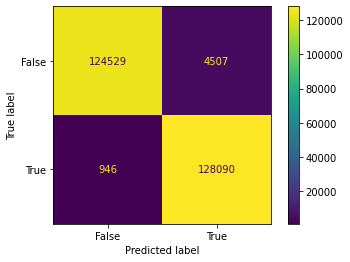

In [10]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

threshould =0.5

y_predict_class = [1 if p > threshould else 0 for p in y_pred]
confusion_matrix = metrics.confusion_matrix(y, y_predict_class)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show() 


**Test Set Accuracy**

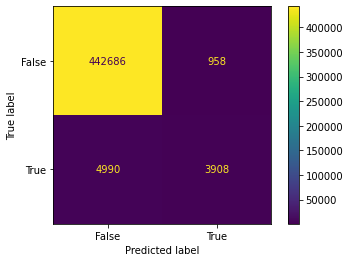

Accuracy when threshould =  0.8 0.986856


In [14]:
x_test_array = np.array(X_test_normalized)
y_test_array = np.array(y_test)
y_pred_test_set = regressor.predict(x_test_array)


threshould =0.8


y_predict_test_set_class = [1 if p > threshould else 0 for p in y_pred_test_set]
confusion_matrix = metrics.confusion_matrix(y_test_array, y_predict_test_set_class)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show() 

print("Accuracy when threshould = ",threshould, round(accuracy_score(y_test_array, y_predict_test_set_class), 6))